In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_excel('round4.xlsx')
df_complete = df[df['Completed'] > 0]
df_complete = df[df['School_Decision'] == "Admit"]

In [5]:
df_complete['Race'].fillna("nan", inplace=True)
df_complete['Sex'].fillna("nan", inplace=True)
df_complete['Native Language'].fillna("nan", inplace=True)
df_complete['Citizenship'].fillna("nan", inplace=True)
df_complete['Have you ever failed a course?'].fillna("nan", inplace=True)
df_complete['GRE Verified'].fillna("No", inplace=True)
df_complete['School_Decision']=df_complete['School_Decision'].replace("Waitlist", "Deny")
df_complete['Overall_GPA'].fillna(0, inplace=True)
df_complete['student_Decision'].fillna("nan",inplace=True)
df_complete['Tuition Percentage'].fillna("nan",inplace=True)
df_complete['Tuition Percentage']=df_complete['Tuition Percentage'].replace("nan",0)
df_complete['student_Decision']=df_complete['student_Decision'].replace("nan", "Decline Offer")
df_complete['student_Decision']=df_complete['student_Decision'].replace("No Response", "Decline Offer")
df_complete['student_Decision']=df_complete['student_Decision'].replace("Defer", "Decline Offer")
df_complete['Race']=LabelEncoder().fit_transform(df_complete['Race'])
df_complete['Native Language']=LabelEncoder().fit_transform(df_complete['Native Language'])
df_complete['Citizenship']=LabelEncoder().fit_transform(df_complete['Citizenship'])
df_complete['GRE Verified']=LabelEncoder().fit_transform(df_complete['GRE Verified'])
df_complete['School_Decision']=LabelEncoder().fit_transform(df_complete['School_Decision'])
df_complete['Sex']=LabelEncoder().fit_transform(df_complete['Sex'])
df_complete['student_Decision']=LabelEncoder().fit_transform(df_complete['student_Decision'])

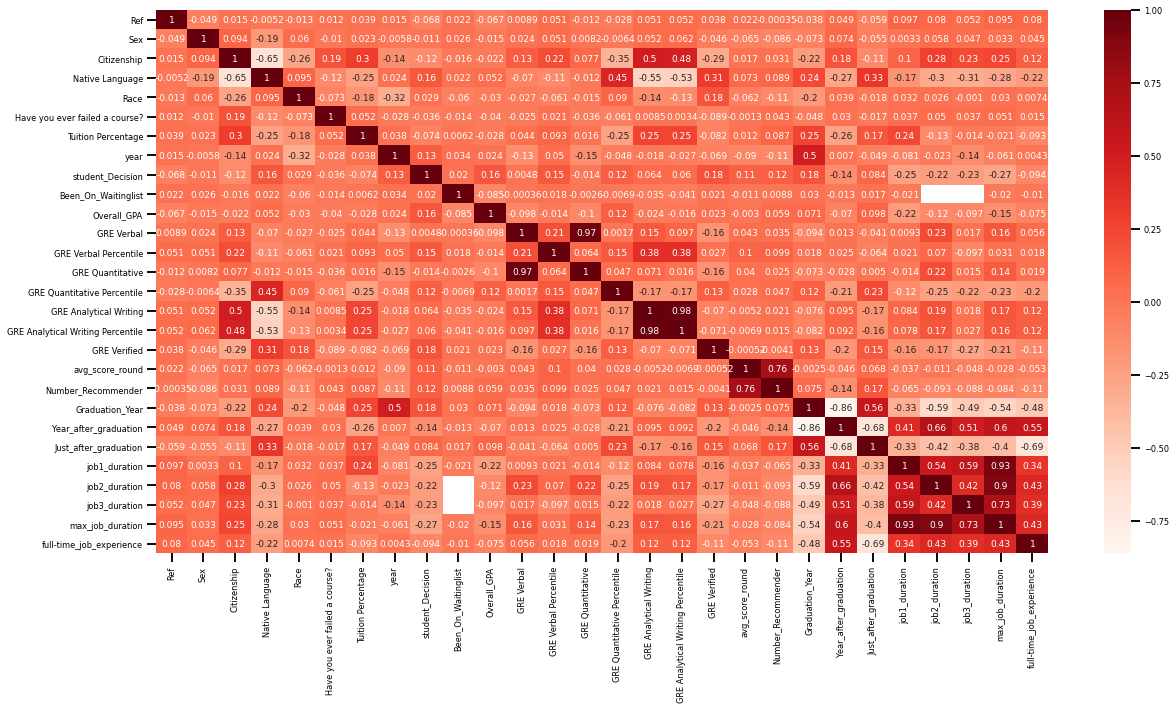

In [6]:
#Heatmap
df1=df_complete.copy()
# df1=df1.drop(['student_Decision'], axis=1)
df1=df1.drop(['Completed'], axis=1)
df1=df1.drop(['School_Decision'], axis=1)
plt.figure(figsize = (20,10))
sns.set_context('talk', font_scale = 0.5)
sns.heatmap(df1.iloc[:,1:].corr(), cmap = 'Reds', annot = True)

## Different imputation methods

In [7]:
#fill nan in GRE with median, mean 
m1 = df_complete.copy()
verbal = m1['GRE Verbal Percentile'].mean()
writing = m1['GRE Analytical Writing Percentile'].mean()
quant = m1['GRE Quantitative Percentile'].mean()
m1['GRE Verbal Percentile'].fillna(verbal, inplace=True)
m1['GRE Analytical Writing Percentile'].fillna(writing, inplace=True)
m1['GRE Quantitative Percentile'].fillna(quant, inplace=True)

verbal_mean = m1['GRE Verbal'].mean()
writing_mean = m1['GRE Analytical Writing'].mean()
quant_mean = m1['GRE Quantitative'].mean()
m1['GRE Verbal'].fillna(verbal_mean, inplace=True)
m1['GRE Analytical Writing'].fillna(writing_mean, inplace=True)
m1['GRE Quantitative'].fillna(quant_mean, inplace=True)

m2 = df_complete.copy()
verbal_median = m2['GRE Verbal Percentile'].median()
writing_median = m2['GRE Analytical Writing Percentile'].median()
quant_median = m2['GRE Quantitative Percentile'].median()
m2['GRE Verbal Percentile'].fillna(verbal_median, inplace=True)
m2['GRE Analytical Writing Percentile'].fillna(writing_median, inplace=True)
m2['GRE Quantitative Percentile'].fillna(quant_median, inplace=True)

verbal_med = m2['GRE Verbal'].median()
writing_med = m2['GRE Analytical Writing'].median()
quant_med = m2['GRE Quantitative'].median()
m2['GRE Verbal'].fillna(verbal_med, inplace=True)
m2['GRE Analytical Writing'].fillna(writing_med, inplace=True)
m2['GRE Quantitative'].fillna(quant_med, inplace=True)

In [8]:
m3 = df_complete.copy()
m3.reset_index(inplace=True)

# m3.boxplot(column=['GRE Verbal Percentile','GRE Quantitative Percentile'],figsize=(15,8),fontsize=18)
# m3.boxplot(column=['GRE Verbal','GRE Quantitative'],figsize=(15,8),fontsize=18)
#many outliers, so can't use k-NN
#Using Multivariate Imputation by Chained Equation (MICE), Iterative Imputation With IterativeImputer
# from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
imputer = imputer = IterativeImputer(max_iter=100, random_state=100, initial_strategy="most_frequent")
attr = [ 'Sex', 'Citizenship', 'Native Language', 'Race',
       'Have you ever failed a course?','Tuition Percentage','GRE Verbal','GRE Quantitative','GRE Analytical Writing',
        'GRE Verbal Percentile','GRE Quantitative Percentile','GRE Analytical Writing Percentile']
# X1 = m3[['GRE Verbal','GRE Quantitative','GRE Analytical Writing']]
# X1 = m3[['GRE Verbal Percentile','GRE Quantitative Percentile','GRE Analytical Writing Percentile']]
X1 = m3[attr]
# X2.corr()
imputer.fit(X1)
iteration = imputer.transform(X1)
m3 = pd.concat([m3, pd.DataFrame(iteration)], axis=1)
# m3.rename(columns={0: 'Verbal',1:'Quantitative',2:'Writing'},inplace=True)
# m3.rename(columns={9: 'Verbal Percentile',10:'Quant Percentile',11:'Writing Percentile'},inplace=True)
m3['Tuition Percentage'] = m3[5]
m3['GRE Verbal Percentile'] = m3[9]
m3['GRE Quantitative Percentile'] = m3[10]
m3['GRE Analytical Writing Percentile'] = m3[11]
m3.head(10)

,index,Unnamed: 0,Ref,Sex,Citizenship,Native Language,Race,Have you ever failed a course?,Sub-Category,Birth Country,Tuition Percentage,year,Completed,School_Decision,student_Decision,final_Decision,Been_On_Waitinglist,Overall_GPA,GRE Verbal,GRE Verbal Percentile,GRE Quantitative,GRE Quantitative Percentile,GRE Analytical Writing,GRE Analytical Writing Percentile,GRE Verified,avg_score_round,Number_Recommender,Graduation_Year,Graduation_Country,Year_after_graduation,Just_after_graduation,job1_duration,job2_duration,job3_duration,max_job_duration,full-time_job_experience,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,723116564,0,0,11,4,0,Computational Methods,IN,40.0,2021,1,0,0,Accept Offer,0,3.560,157.0,75.000000,168.0,92.000000,3.5,38.000000,1,5,3,2017.0,India,4.0,0.0,NaN,NaN,NaN,NaN,0,0.0,0.0,11.0,4.0,0.0,40.0,157.000000,168.000000,3.500000,75.000000,92.000000,38.000000
1,7,10,57943445,1,0,24,11,0,Statistical Methodology,BE,40.0,2020,1,0,1,Defer,0,2.920,163.0,93.000000,166.0,89.000000,4.5,81.000000,1,5,3,2019.0,Belgium,1.0,1.0,396.0,943.0,NaN,31.0,0,1.0,0.0,24.0,11.0,0.0,40.0,163.000000,166.000000,4.500000,93.000000,89.000000,81.000000
2,8,11,57943445,1,0,24,11,0,Statistical Methodology,BE,40.0,2021,1,0,1,Decline Offer,0,2.920,163.0,93.000000,166.0,89.000000,4.5,81.000000,1,0,0,2019.0,Belgium,2.0,0.0,396.0,943.0,NaN,31.0,1,1.0,0.0,24.0,11.0,0.0,40.0,163.000000,166.000000,4.500000,93.000000,89.000000,81.000000
3,11,18,960656601,1,2,7,2,0,Health and Biomedical Sciences,US,50.0,2019,1,0,1,Defer,0,3.130,155.0,68.000000,155.0,59.000000,4.0,59.000000,1,4,3,2015.0,US,4.0,0.0,NaN,92.0,304.0,10.0,1,1.0,2.0,7.0,2.0,0.0,50.0,155.000000,155.000000,4.000000,68.000000,59.000000,59.000000
4,12,19,960656601,1,2,7,2,0,Health and Biomedical Sciences,US,50.0,2020,1,0,0,Accept Offer,0,3.130,155.0,68.000000,155.0,59.000000,4.0,59.000000,1,0,0,2015.0,US,5.0,0.0,NaN,92.0,304.0,10.0,1,1.0,2.0,7.0,2.0,0.0,50.0,155.000000,155.000000,4.000000,68.000000,59.000000,59.000000
5,13,20,119431651,1,0,39,11,0,Statistical Methodology,NI,40.0,2020,1,0,1,No Response,0,3.752,144.0,22.000000,159.0,70.000000,3.5,39.000000,1,5,3,2019.0,Nigeria,1.0,1.0,NaN,61.0,NaN,2.0,0,1.0,0.0,39.0,11.0,0.0,40.0,144.000000,159.000000,3.500000,22.000000,70.000000,39.000000
6,14,21,875963296,0,1,34,9,0,Statistical Methodology,GH,50.0,2019,1,0,1,No Response,0,0.000,NaN,68.560830,NaN,89.718335,NaN,37.021572,0,3,3,NaN,NaN,NaN,NaN,NaN,457.0,120.0,15.0,0,0.0,1.0,34.0,9.0,0.0,50.0,161.241420,174.668694,3.500938,68.560830,89.718335,37.021572
7,18,26,102323454,1,2,7,9,1,Statistical Methodology,US,75.0,2016,1,0,0,Melt,0,3.470,NaN,72.926564,NaN,80.473219,NaN,58.290338,0,4,3,2016.0,US,0.0,1.0,NaN,61.0,NaN,2.0,0,1.0,2.0,7.0,9.0,1.0,75.0,164.850723,173.325356,4.064849,72.926564,80.473219,58.290338
8,22,33,678906503,1,0,11,11,0,Statistical Methodology,IN,40.0,2018,1,0,0,Accept Offer,0,0.000,150.0,48.000000,170.0,97.000000,3.5,42.000000,0,4,3,NaN,US,NaN,NaN,NaN,61.0,913.0,30.0,0,1.0,0.0,11.0,11.0,0.0,40.0,150.000000,170.000000,3.500000,48.000000,97.000000,42.000000
9,25,38,622481782,1,0,9,11,1,Statistical Methodology,IR,40.0,2021,1,0,0,Accept Offer,0,0.000,NaN,66.546114,NaN,84.253805,NaN,51.619145,0,0,0,2020.0,Iran,1.0,1.0,1125.0,973.0,852.0,38.0,0,1.0,0.0,9.0,11.0,1.0,40.0,156.778888,165.358100,3.839798,66.546114,84.253805,51.619145


In [21]:
def dataSplit_pre(df_raw):
    feature_cols = ['Race','Native Language','Citizenship','Tuition Percentage','Overall_GPA','GRE Verbal Percentile','GRE Quantitative Percentile']
    x= df_raw[feature_cols]
    y2 = df_raw['student_Decision']
    x_train, x_test, y_train, y_test = train_test_split(x, y2 , test_size=0.2, random_state=1234)
    result_set = {}
    result_set['x_train'] = x_train
    result_set['x_test'] = x_test
    result_set['y_train'] = y_train
    result_set['y_test'] = y_test
    return result_set

def random_forest(dataset):
    rf = RandomForestClassifier()
    rf.fit(dataset['x_train'], dataset['y_train'])
    pred = rf.predict(dataset['x_test'])
    feature_cols = ['Race','Native Language','Citizenship','Tuition Percentage','Overall_GPA','GRE Verbal Percentile','GRE Quantitative Percentile']
    result_set = {}
    result_set['Accuracy'] = accuracy_score(dataset['y_test'], pred)
    matrix = metrics.confusion_matrix(dataset['y_test'], pred)
    result_set['Confusion Matrix'] = matrix
#     print("Roc_Auc_Score: ", roc_auc_score(y_test, pred))
    return result_set,get_feature_importance(rf,feature_cols),rf

def knn(dataset):
    knn = KNeighborsClassifier(n_neighbors = 30)
    knn.fit(dataset['x_train'], dataset['y_train'])
    pred = knn.predict(dataset['x_test'])
    result_set = {}
    result_set['Accuracy'] = accuracy_score(dataset['y_test'], pred)
    matrix = metrics.confusion_matrix(dataset['y_test'], pred)
    result_set['Confusion Matrix'] = matrix
    return result_set,knn

def decision_tree(dataset):
    dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
    dt.fit(dataset['x_train'], dataset['y_train'])
    pred = dt.predict(dataset['x_test'])
#     print(classification_report(Y_test, Y_pred))
    feature_cols = ['Race','Native Language','Citizenship','Tuition Percentage','Overall_GPA','GRE Verbal Percentile','GRE Quantitative Percentile']    
    result_set = {}
    result_set['Accuracy'] = accuracy_score(dataset['y_test'], pred)
    matrix = metrics.confusion_matrix(dataset['y_test'], pred)
    result_set['Confusion Matrix'] = matrix
    
    fig = plt.figure(figsize=(50,35))
    _ = tree.plot_tree(dt, feature_names= feature_cols, class_names = ['Accept', 'Decline'], filled=True, fontsize = 17)
    fig.savefig("tree.pdf",bbox_inches='tight')
    return result_set,get_feature_importance(dt,feature_cols),dt

def model_eva(dataset):
    dataset=dataSplit_pre(dataset)
    print('-------------------------------------------')
    print('Random Forest: ')
    rf=random_forest(dataset)
    print(rf[0]['Accuracy'])
    print(rf[0]['Confusion Matrix'])
    print(rf[1])
    print('-------------------------------------------')
    print('KNN: ')
    kns=knn(dataset)
    print(kns[0]['Accuracy'])
    print(kns[0]['Confusion Matrix'])
    print('-------------------------------------------')
    print('Decision Tree: ')
    dt=decision_tree(dataset)
    print(dt[0]['Accuracy'])
    print(dt[0]['Confusion Matrix'])
    print(dt[1])
    
    rf_auc_curve = plot_roc_curve(rf[2], dataset['x_test'], dataset['y_test'])
    knn_auc_curve = plot_roc_curve(kns[1], dataset['x_test'], dataset['y_test'], ax=rf_auc_curve.ax_)
    dt_auc_curve = plot_roc_curve(dt[2],dataset['x_test'], dataset['y_test'], ax=rf_auc_curve.ax_)
    rf_auc_curve.figure_.suptitle("ROC curve comparison",fontsize=20)
    plt.rcParams.update({'figure.figsize': (10,5)})
#     plt.figure(figsize=(15,10)) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("False Positive Rate",fontsize=16)
    plt.ylabel("True Positive Rate",fontsize=16)
    plt.legend(fontsize=12) 
    plt.show()

In [22]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

Mean: 
-------------------------------------------
Random Forest: 
0.6964285714285714
[[ 25  46]
 [ 22 131]]
                          feat     score
4                  Overall_GPA  0.353065
5        GRE Verbal Percentile  0.225135
6  GRE Quantitative Percentile  0.157039
3           Tuition Percentage  0.115114
1              Native Language  0.084184
0                         Race  0.044975
2                  Citizenship  0.020488
-------------------------------------------
KNN: 
0.7544642857142857
[[ 21  50]
 [  5 148]]
-------------------------------------------
Decision Tree: 
0.7589285714285714
[[ 25  46]
 [  8 145]]
                          feat     score
4                  Overall_GPA  0.330734
3           Tuition Percentage  0.290641
5        GRE Verbal Percentile  0.250307
6  GRE Quantitative Percentile  0.052225
1              Native Language  0.052122
0                         Race  0.023971
2                  Citizenship  0.000000


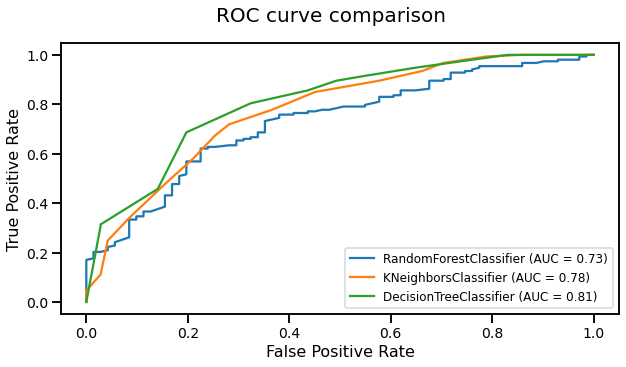

In [23]:
print('Mean: ')
model_eva(m1)

Median: 
-------------------------------------------
Random Forest: 
0.7008928571428571
[[ 25  46]
 [ 21 132]]
                          feat     score
4                  Overall_GPA  0.354488
5        GRE Verbal Percentile  0.225618
6  GRE Quantitative Percentile  0.151977
3           Tuition Percentage  0.112916
1              Native Language  0.081284
0                         Race  0.049751
2                  Citizenship  0.023967
-------------------------------------------
KNN: 
0.7633928571428571
[[ 23  48]
 [  5 148]]
-------------------------------------------
Decision Tree: 
0.7589285714285714
[[ 25  46]
 [  8 145]]
                          feat     score
4                  Overall_GPA  0.330734
3           Tuition Percentage  0.290641
5        GRE Verbal Percentile  0.250307
6  GRE Quantitative Percentile  0.052225
1              Native Language  0.052122
0                         Race  0.023971
2                  Citizenship  0.000000


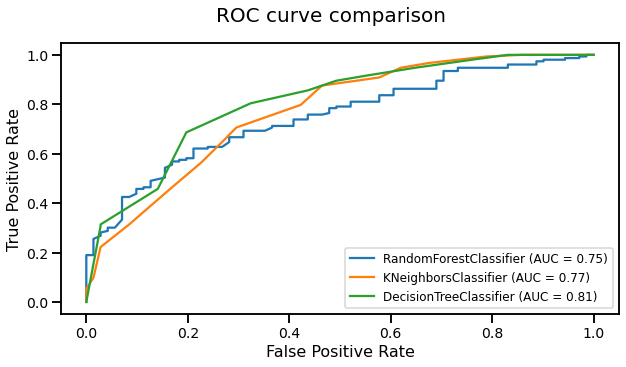

In [25]:
print('Median: ')
model_eva(m2)

MICE: 
-------------------------------------------
Random Forest: 
0.6875
[[ 23  48]
 [ 22 131]]
                          feat     score
4                  Overall_GPA  0.323461
5        GRE Verbal Percentile  0.254506
6  GRE Quantitative Percentile  0.192909
3           Tuition Percentage  0.104071
1              Native Language  0.068239
0                         Race  0.039372
2                  Citizenship  0.017442
-------------------------------------------
KNN: 
0.7410714285714286
[[ 19  52]
 [  6 147]]
-------------------------------------------
Decision Tree: 
0.78125
[[ 27  44]
 [  5 148]]
                          feat     score
3           Tuition Percentage  0.265935
4                  Overall_GPA  0.265305
5        GRE Verbal Percentile  0.222927
6  GRE Quantitative Percentile  0.209504
1              Native Language  0.036329
0                         Race  0.000000
2                  Citizenship  0.000000


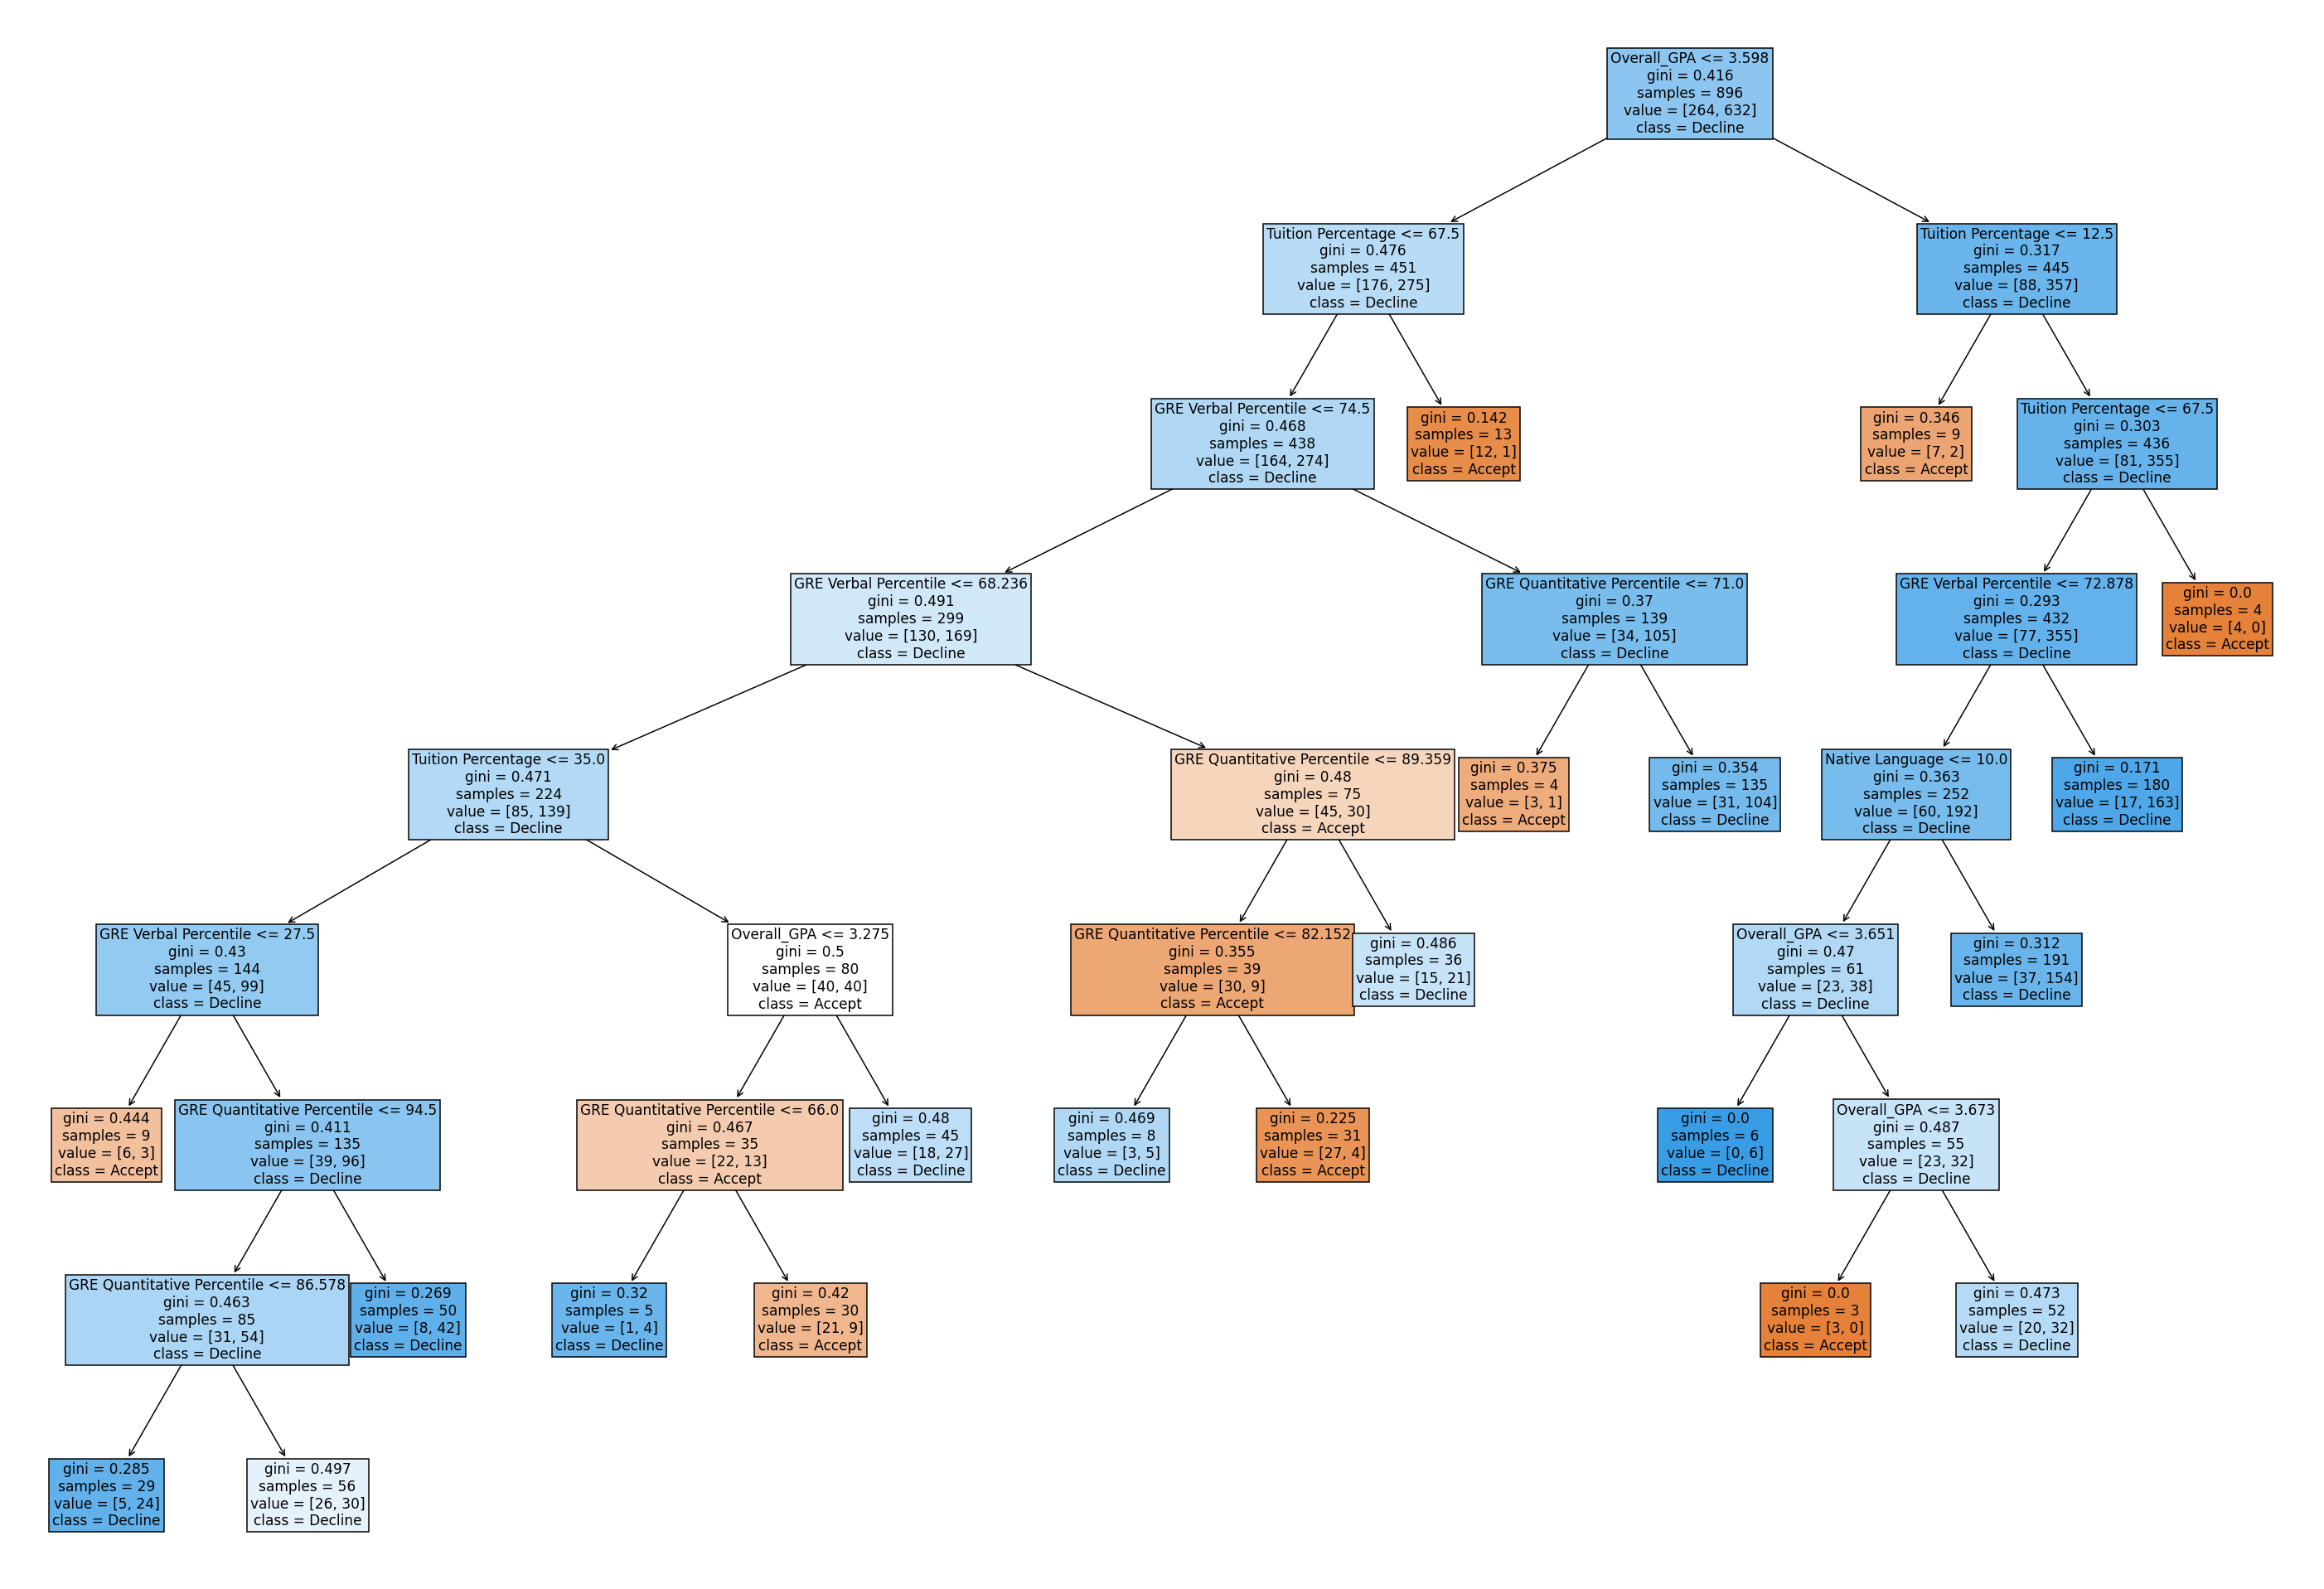

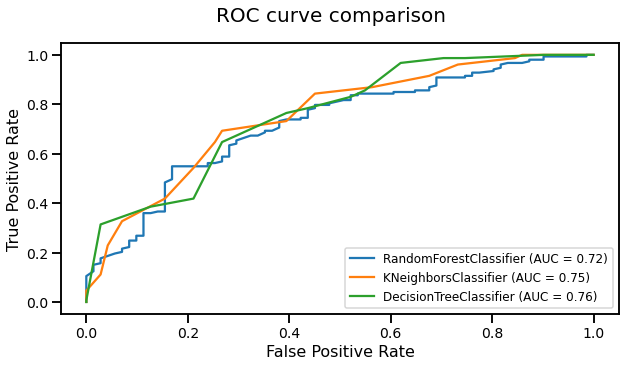

In [23]:
print('MICE: ')
model_eva(m3)